<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Outline" data-toc-modified-id="Chapter-Outline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter Outline</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Read-in-the-data" data-toc-modified-id="Read-in-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read in the data</a></span></li><li><span><a href="#Calculate-Performance" data-toc-modified-id="Calculate-Performance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate Performance</a></span></li><li><span><a href="#Evaluate-Performance" data-toc-modified-id="Evaluate-Performance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluate Performance</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

# import standard libs
from pathlib import Path
import sys
import time
import os
from copy import copy

# get project dir
pp = Path(Path.cwd()).parts[:-1]
pdir = Path(*pp)
data_dir = pdir/'data'
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import monthly_returns_heatmap as mrh
import math
import ffn
import pyfolio as pf

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
savefig_kwds=dict(dpi=300, bbox_inches='tight')

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import *

print()
%watermark --iversion

2019-05-07T16:43:29-06:00

CPython 3.7.2
IPython 6.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.19.11-041911-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /tmp/try_flags_a4bmjvxk.c:3:0:\n/usr/include/stdio.h:27:10: fatal error: bits/libc-header-start.h: No such file or directory\n #include <bits/libc-header-start.h>\n          ^~~~~~~~~~~~~~~~~~~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 980 Ti (0000:01:00.0)



json        2.0.9
numpy       1.16.2
pandas      0.24.2
pandas_datareader  0.7.0
monthly_returns_heatmap  0.0.11
ffn         (0, 3, 4)
pyfolio     0.9.0
matplotlib  3.0.2
seaborn     0.9.0
PIL.Image   5.4.1



In [2]:
%load_ext nb_black

sns_params = {
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "font.size": 11,
    "font.weight": "medium",
    "figure.figsize": (10, 7),
    "font.family": "Ubuntu Mono",
}

sns.set_style("white", sns_params)
sns.set_context(sns_params)
savefig_kwds = dict(dpi=90, bbox_inches="tight", frameon=True, format="png")
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f4cae4"]
sns.set_palette(sns.color_palette(flatui, 7))


def save_image(fig, fn):
    fig.savefig(Path(viz / f"{fn}.png").as_posix(), **savefig_kwds)
    print(f"image saved: {fn}")
    return

<IPython.core.display.Javascript object>

## Chapter Outline

1. Introduction
2. Import algorithm backtest data
3. Evaluate algorithm results
4. Conclusions
5. Resource and Citations

## Introduction

After learning that the Gaussian Mixture Model and the historical VAR models were relatively effective in forecasting VAR I  decided to test an inverse VAR portfolio allocation algorithm verse some common benchmarks. 

The symbol universe consisted of the following ETFs:

_"SPY", "QQQ", "DIA", "TLT", "GLD", "EFA", "EEM", 'BND', 'VNQ'_

- All the algorithms start from `2007-12-31` and run until `2019-05-08`. 
- Rebalance monthly
- Target weights had a 5% corridor or +/- 2.5% (to minimize transaction costs). 

The benchmark algorithms are the equal weight and 60/40 SPY/BND algorithm. 

I tested 2 Historical VAR models. One with a lookback of 252 days and the other with a lookback 60 days. 

I tested 2 GMM VAR models. One with a lookback of 252 days and the other, 60 days. I restricted the model to 2 components.

## Read in the data

In [3]:
def read_bt_json(fp):
    """fn: read Quantconnect backtest json"""
    with open(fp, encoding="utf-8") as f_in:
        return json.load(f_in)


def extract_portfolio_equity(jdata):
    """fn: extract port equity timeseries from Quantconnect json"""
    d = jdata["Charts"]["Strategy Equity"]["Series"]["Equity"]["Values"]
    equity = (
        pd.DataFrame(d)
        .rename(columns=dict(x="time", y="equity"))
        .assign(time=lambda df: pd.to_datetime(df.time, utc=True, unit="s"))
        .set_index("time")
    )
    return equity


def _get_column_name(text):
    """fn: to get column name as first text group"""
    # n = 4 # hardcoded based on fn structure
    groups = text.split(".")
    return "_".join(groups[:-1])


def read_port_equity(dir_, fn):
    fp = Path(dir_ / fn)  # .as_posix()
    jdata = read_bt_json(fp)

    # get column name
    col = _get_column_name(fn)
    # extract equity data
    equity = extract_portfolio_equity(jdata).rename(columns=dict(equity=col))
    return equity

<IPython.core.display.Javascript object>

In [4]:
filenames = [
    "equal_weight_benchmark_[2019-05]",
    "60_40_benchmark_[2019-05]",
    "gmm2_60_[2019-05]",
    "gmm2_252_[2019-05]",
    "historical_60_[2019-05]",
    "historical_252_[2019-05]",
]

dfs = [read_port_equity(Path(pdir / "data"), f"{fn}.json") for fn in filenames]
df = pd.concat(dfs, axis=1).sort_index().dropna().drop_duplicates()
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           equal_weight_benchmark_[2019-05]  \
time                                                          
2019-05-02 20:00:00+00:00                      208,709.9848   
2019-05-03 17:03:00+00:00                      210,300.5198   
2019-05-03 20:00:00+00:00                      210,445.3648   
2019-05-06 13:31:00+00:00                      207,961.7448   
2019-05-06 20:00:00+00:00                      209,486.4098   

                           60_40_benchmark_[2019-05]  gmm2_60_[2019-05]  \
time                                                                      
2019-05-02 20:00:00+00:00               211,104.8538       195,237.2408   
2019-05-03 17:03:00+00:00               212,385.3838       196,455.0358   
2019-05-03 20:00:00+00:00               212,444.9538       196,570.1258   
2

<IPython.core.display.Javascript object>

## Calculate Performance

In [5]:
def to_price_index(df, start=1):
    return start * (np.exp(df.cumsum()))


def common_sense_ratio(returns):
    # common sense ratio
    ratio = (abs(returns.quantile(0.95)) * returns[returns > 0].sum()) / abs(
        abs(returns.quantile(0.05)) * returns[returns < 0].sum()
    )
    ratio = round(ratio, 2)
    return ratio


def plot_pf(returns):
    plots = [
        pf.plot_rolling_returns,
        pf.plot_annual_returns,
        pf.plot_monthly_returns_heatmap,
        pf.plot_monthly_returns_dist,
        pf.plot_drawdown_underwater,
    ]

    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1.0, 1, 1])

    for i, func in enumerate(plots):

        if i == 0:
            ax = plt.subplot(gs[0, :])
            func(returns, ax=ax)
        elif i < 4:
            ax = plt.subplot(gs[1, i - 1])
            func(returns, ax=ax)
        elif i == 4:
            ax = plt.subplot(gs[2, :])
            func(returns, ax=ax)
        else:
            continue

    plt.tight_layout()


# keep_stats = test.index[0:7].tolist() + test.index[16:].tolist()
keep_stats = [
    "start",
    "end",
    "rf",
    "total_return",
    "cagr",
    "max_drawdown",
    "calmar",
    "daily_sharpe",
    "daily_sortino",
    "daily_mean",
    "daily_vol",
    "daily_skew",
    "daily_kurt",
    "best_day",
    "worst_day",
    "monthly_sharpe",
    "monthly_sortino",
    "monthly_mean",
    "monthly_vol",
    "monthly_skew",
    "monthly_kurt",
    "best_month",
    "worst_month",
    "yearly_sharpe",
    "yearly_sortino",
    "yearly_mean",
    "yearly_vol",
    "yearly_skew",
    "yearly_kurt",
    "best_year",
    "worst_year",
    "avg_drawdown",
    "avg_drawdown_days",
    "avg_up_month",
    "avg_down_month",
    "win_year_perc",
    "twelve_month_win_perc",
]


def view_strats(strats):
    return ffn.calc_stats(strats).stats.loc[keep_stats]


strats = pd.DataFrame()

# plot helper for labeling scatter plot
def label_point(x, y, val, ax, rotation=10, ha="center", va="baseline"):
    """
    label points on a scatter plot

    See:
        https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
    :param x: pd.Series
    :param y: pd.Series
    :param val: pd.Series
    :param ax: matplotlib axis
    :return:
    """
    a = pd.concat({"x": x, "y": y, "val": val}, axis=1).dropna()
    for i, point in a.iterrows():
        ax.text(
            point["x"],
            point["y"],
            str(point["val"]),
            rotation=rotation,
            horizontalalignment=ha,
            verticalalignment=va,
        )

<IPython.core.display.Javascript object>

In [6]:
for col in df.columns:
    strats[col] = np.log(df[col] / df[col].shift(1))
cprint(strats)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           equal_weight_benchmark_[2019-05]  \
time                                                          
2019-05-02 20:00:00+00:00                            0.0018   
2019-05-03 17:03:00+00:00                            0.0076   
2019-05-03 20:00:00+00:00                            0.0007   
2019-05-06 13:31:00+00:00                           -0.0119   
2019-05-06 20:00:00+00:00                            0.0073   

                           60_40_benchmark_[2019-05]  gmm2_60_[2019-05]  \
time                                                                      
2019-05-02 20:00:00+00:00                     0.0024             0.0016   
2019-05-03 17:03:00+00:00                     0.0060             0.0062   
2019-05-03 20:00:00+00:00                     0.0003             0.0006   
2

<IPython.core.display.Javascript object>

In [7]:
# create strategy result df which holds all the computed metrics
strat_res = pd.concat(
    [view_strats(df[col].dropna()).rename(col) for col in strats.columns], axis=1
)

# add common sense ratios
common_sense_ratios = pd.Series(
    [common_sense_ratio(strats[col].dropna()) for col in strats.columns],
    index=strats.columns,
)

strat_res.loc["common_sense_ratio"] = common_sense_ratios

# add avg of worst 5 drawdown durations in days
avg_worst_5_drawdowns_duration = pd.Series(
    [
        pf.timeseries.gen_drawdown_table(strats[col].dropna()).Duration.iloc[:5].mean()
        for col in strats.columns
    ],
    index=strats.columns,
)
strat_res.loc["avg_worst_5_drawdown_duration"] = avg_worst_5_drawdowns_duration

# add avg of worst 5 drawdowns (%)
avg_worst_5_drawdowns = pd.Series(
    [
        pf.timeseries.gen_drawdown_table(strats[col].dropna())["Net drawdown in %"]
        .iloc[:5]
        .mean()
        * -0.01
        for col in strats.columns
    ],
    index=strats.columns,
)

strat_res.loc["avg_worst_5_drawdowns"] = avg_worst_5_drawdowns

<IPython.core.display.Javascript object>

In [8]:
perf = ffn.calc_stats(df)

<IPython.core.display.Javascript object>

## Evaluate Performance

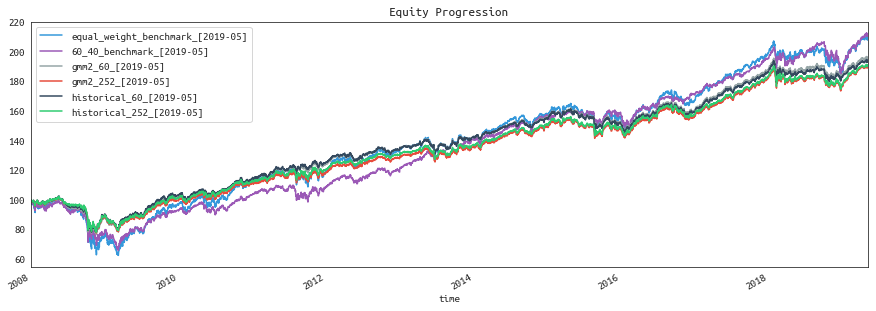

<IPython.core.display.Javascript object>

In [9]:
perf.plot()

In [10]:
strat_res

,equal_weight_benchmark_[2019-05],60_40_benchmark_[2019-05],gmm2_60_[2019-05],gmm2_252_[2019-05],historical_60_[2019-05],historical_252_[2019-05]
start,2007-12-31 05:00:00+00:00,2007-12-31 05:00:00+00:00,2007-12-31 05:00:00+00:00,2007-12-31 05:00:00+00:00,2007-12-31 05:00:00+00:00,2007-12-31 05:00:00+00:00
end,2019-05-06 20:00:00+00:00,2019-05-06 20:00:00+00:00,2019-05-06 20:00:00+00:00,2019-05-06 20:00:00+00:00,2019-05-06 20:00:00+00:00,2019-05-06 20:00:00+00:00
rf,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
total_return,1.0949,1.1204,0.9601,0.9001,0.9398,0.9088
cagr,0.0673,0.0685,0.0611,0.0582,0.0601,0.0586
max_drawdown,-0.3890,-0.3425,-0.2476,-0.2393,-0.2372,-0.2369
calmar,0.1731,0.2000,0.2468,0.2432,0.2535,0.2475
daily_sharpe,0.5303,0.6403,0.7412,0.7095,0.7502,0.7266
daily_sortino,0.8450,1.0008,1.2020,1.1490,1.2138,1.1777
daily_mean,0.0754,0.0728,0.0630,0.0603,0.0619,0.0606


<IPython.core.display.Javascript object>

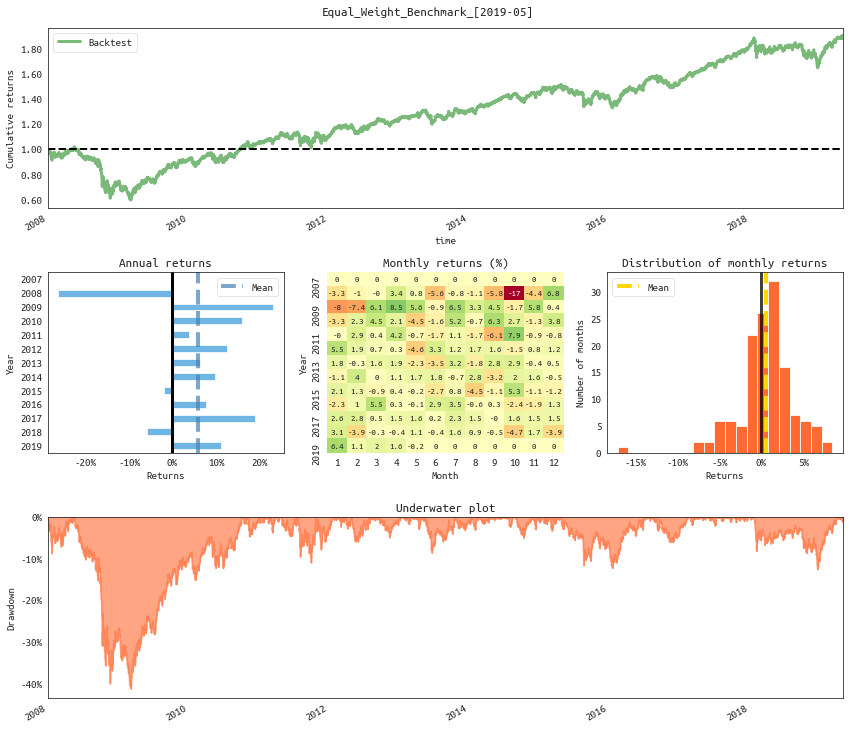

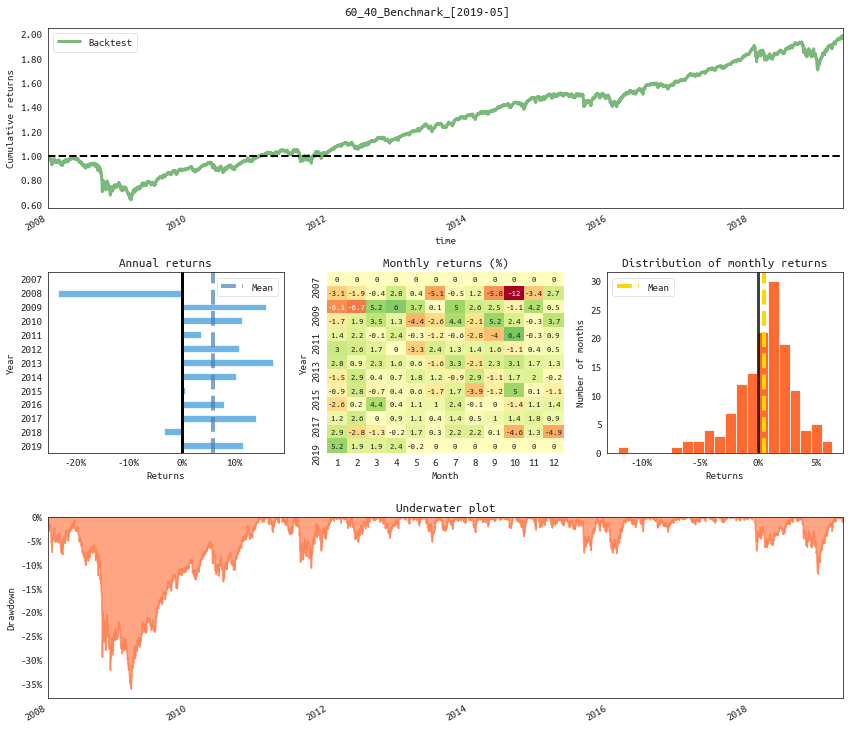

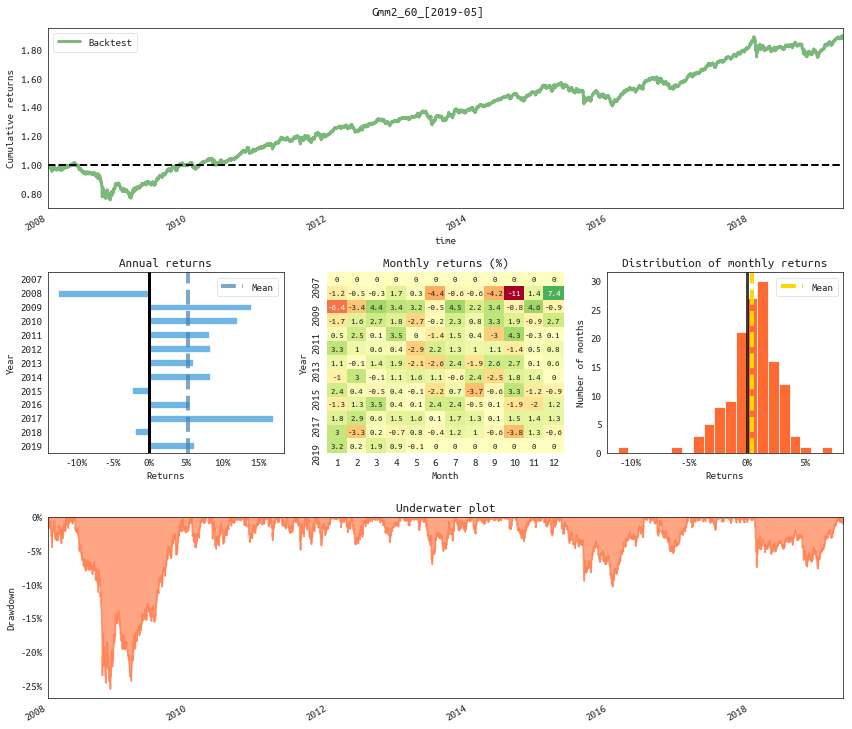

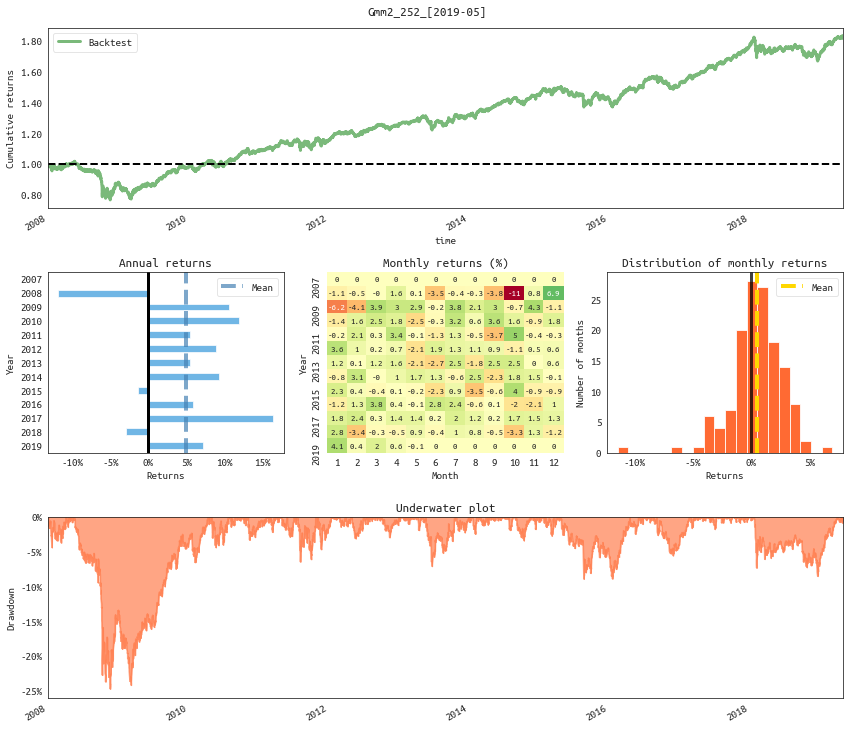

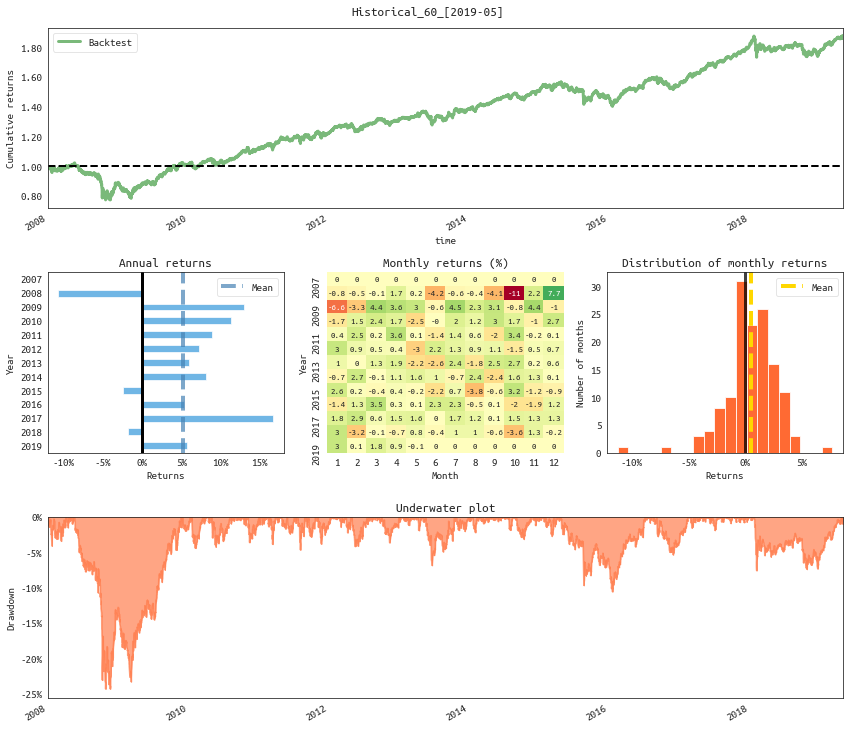

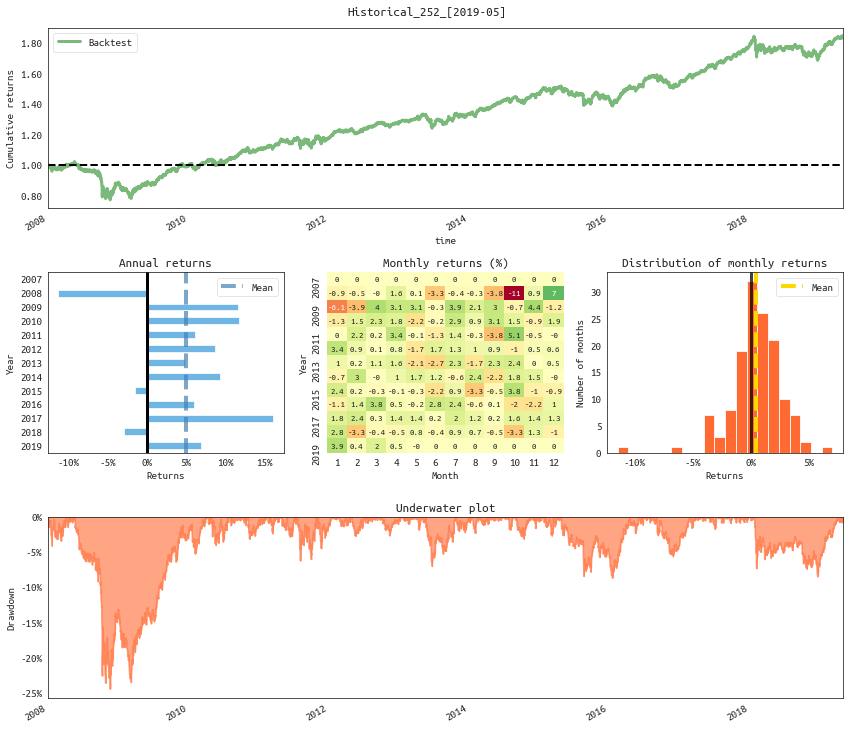

<IPython.core.display.Javascript object>

In [11]:
for col in strats.columns:
    plot_pf(strats[col])
    plt.suptitle(col.title(), y=1.01)

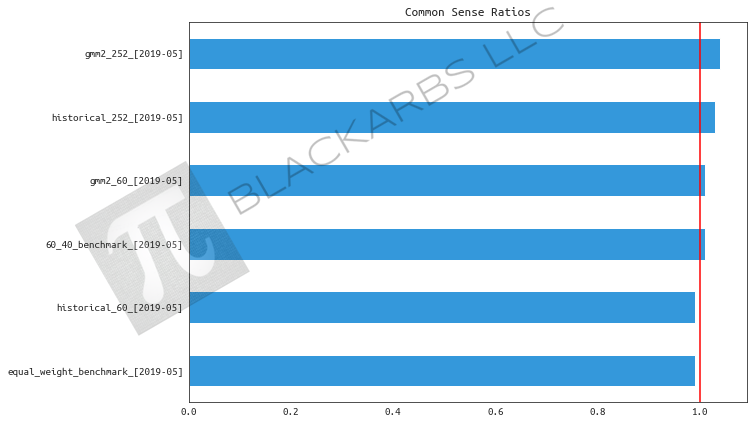

<IPython.core.display.Javascript object>

In [12]:
ax = (
    strat_res.loc["common_sense_ratio"]
    .sort_values()
    .plot.barh(title="Common Sense Ratios")
)

plt.axvline(1.0, color="r")
add_watermark(ax, scale=1.25)

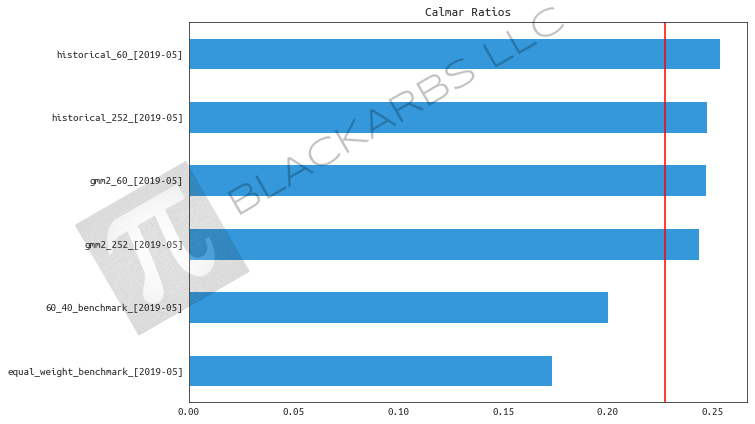

<IPython.core.display.Javascript object>

In [18]:
ax = strat_res.loc["calmar"].sort_values().plot.barh(title="Calmar Ratios")
plt.xlim(0)
plt.axvline(strat_res.loc["calmar"].mean(), color="r")
add_watermark(ax, scale=1.25)

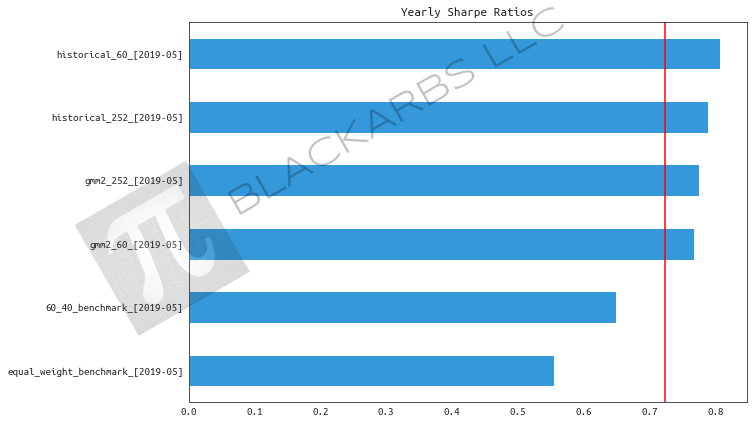

<IPython.core.display.Javascript object>

In [17]:
ax = (
    strat_res.loc["yearly_sharpe"].sort_values().plot.barh(title="Yearly Sharpe Ratios")
)
plt.axvline(strat_res.loc["yearly_sharpe"].mean(), color="r")
add_watermark(ax, scale=1.25)

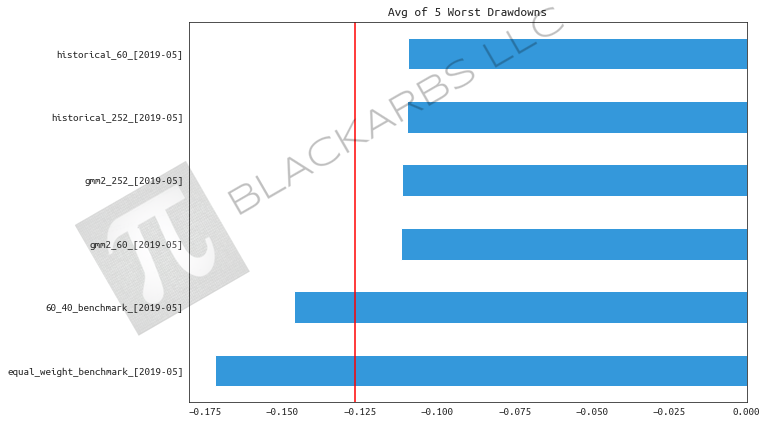

<IPython.core.display.Javascript object>

In [22]:
ax = (
    strat_res.loc["avg_worst_5_drawdowns"]
    .sort_values(ascending=True)
    .plot.barh(title="Avg of 5 Worst Drawdowns")
)
ax.axvline(strat_res.loc["avg_worst_5_drawdowns"].mean(), color="r")
add_watermark(ax, scale=1.25)

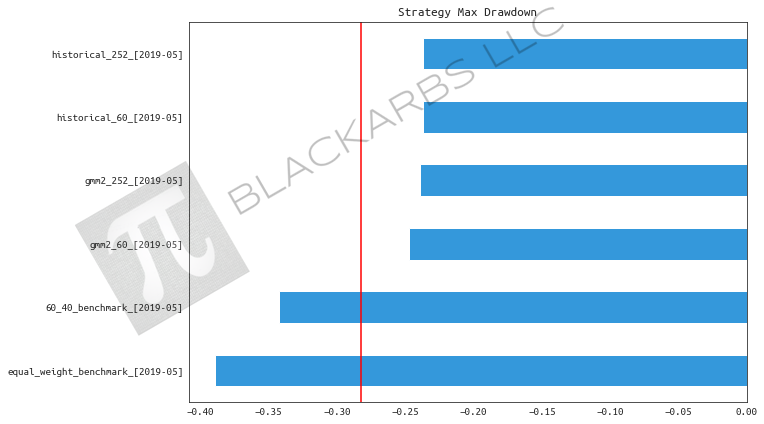

<IPython.core.display.Javascript object>

In [20]:
ax = (
    strat_res.loc["max_drawdown"].sort_values().plot.barh(title="Strategy Max Drawdown")
)
ax.axvline(strat_res.loc["max_drawdown"].mean(), color="r")
add_watermark(ax, scale=1.25)

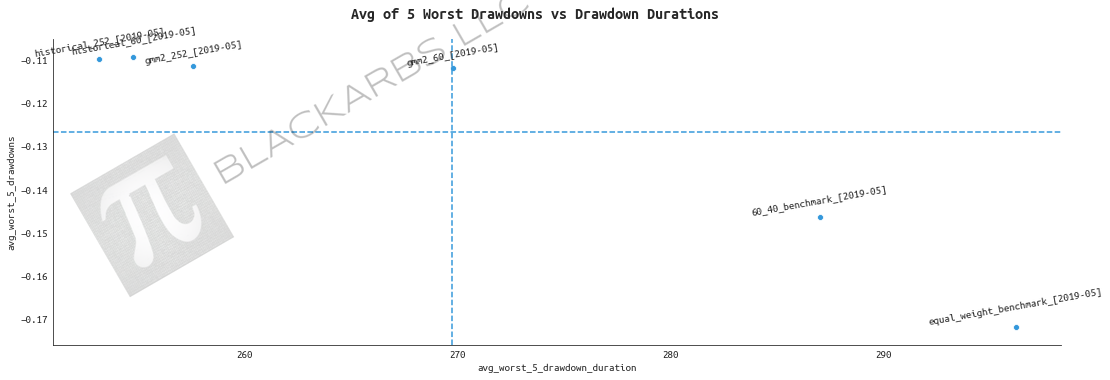

<IPython.core.display.Javascript object>

In [25]:
y = "avg_worst_5_drawdowns"
x = "avg_worst_5_drawdown_duration"

g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
label_point(
    strat_res.T[x],
    strat_res.T[y],
    pd.Series(strat_res.T.index, index=strat_res.T.index),
    plt.gca(),
    va="bottom",
    ha="center",
)
plt.suptitle(
    "Avg of 5 Worst Drawdowns vs Drawdown Durations",
    fontsize=16,
    fontweight="demi",
    y=1.05,
)

plt.gca().axhline(strat_res.loc["avg_worst_5_drawdowns"].mean(), ls="--")
plt.gca().axvline(strat_res.loc["avg_worst_5_drawdown_duration"].mean(), ls="--")

add_watermark(g.fig.axes, scale=2.0)

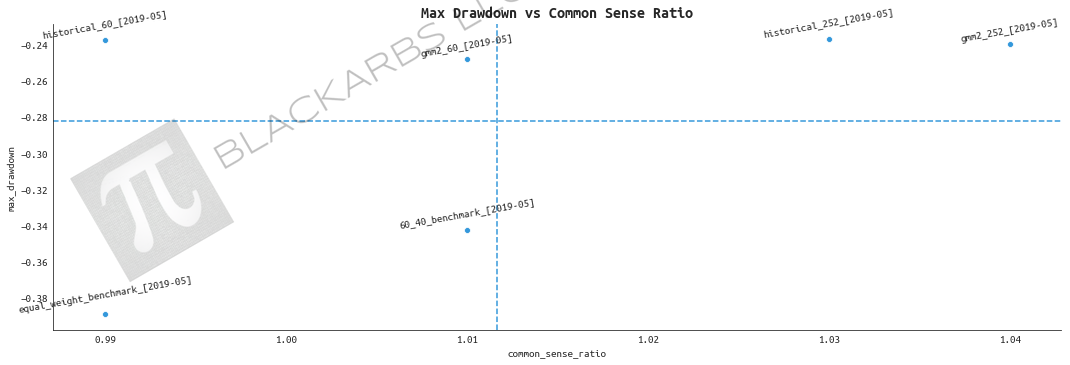

<IPython.core.display.Javascript object>

In [26]:
x = "common_sense_ratio"
y = "max_drawdown"

g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
label_point(
    strat_res.T[x],
    strat_res.T[y],
    pd.Series(strat_res.T.index, index=strat_res.T.index),
    plt.gca(),
    va="bottom",
    ha="center",
)
plt.title("Max Drawdown vs Common Sense Ratio", fontsize=16, fontweight="demi")
add_watermark(g.fig.axes, scale=2.0)
plt.gca().axhline(strat_res.T[y].mean(), ls="--")
plt.gca().axvline(strat_res.T[x].mean(), ls="--")

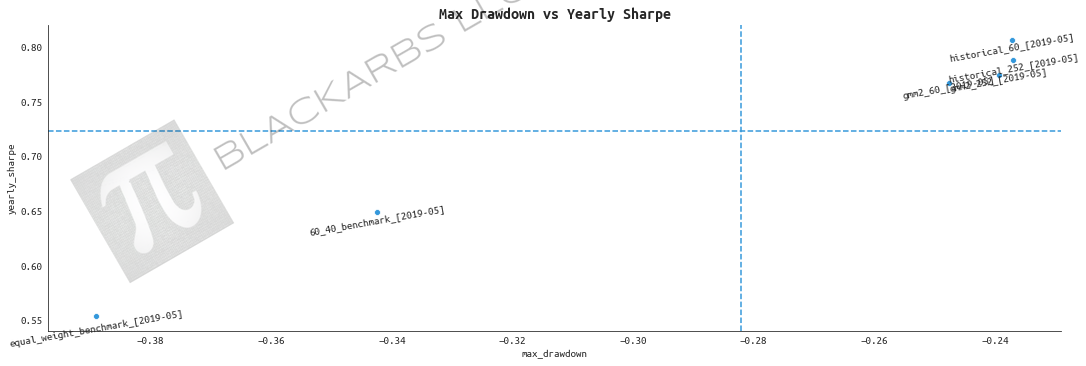

<IPython.core.display.Javascript object>

In [27]:
x = "max_drawdown"
y = "yearly_sharpe"

g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
label_point(
    strat_res.T[x],
    strat_res.T[y],
    pd.Series(strat_res.T.index, index=strat_res.T.index),
    plt.gca(),
)
plt.title("Max Drawdown vs Yearly Sharpe", fontsize=16, fontweight="demi")
add_watermark(g.fig.axes, scale=2.0)
plt.gca().axhline(strat_res.T[y].mean(), ls="--")
plt.gca().axvline(strat_res.T[x].mean(), ls="--")

In [29]:
perf["gmm2_252_[2019-05]"].display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep     Oct    Nov    Dec     YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------  -----  -----  ------
  2007   0      0      0      0      0      0      0      0      0       0      0      0       0
  2008  -1.07  -0.49   0.01   1.66   0.12  -3.45  -0.4   -0.25  -3.68  -10.92   1.04   7.14  -10.73
  2009  -6.08  -4.09   4.02   3.1    2.94  -0.22   3.87   2.17   3.02   -0.68   4.34  -1.1    11.17
  2010  -1.37   1.59   2.52   1.79  -2.45  -0.29   3.18   0.58   3.64    1.67  -0.86   1.85   12.29
  2011  -0.15   2.15   0.3    3.39  -0.08  -1.33   1.3   -0.42  -3.6     5.04  -0.34  -0.27    5.88
  2012   3.57   0.99   0.21   0.72  -2.06   1.95   1.32   1.12   0.94   -1.13   0.54   0.61    9.03
  2013   1.2    0.12   1.25   1.61  -2.08  -2.7    2.47  -1.8    2.51    2.55   0.03   0.58    5.71
  2014  -0.76   3.13   0.01   1.06   1.72   1.27  -0.58   2.48  -2.32    1.81   1.51  -0.1     9.49
  2

<IPython.core.display.Javascript object>

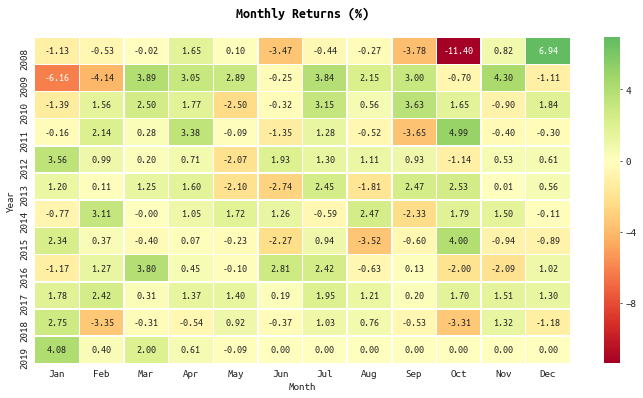

<IPython.core.display.Javascript object>

In [30]:
plt.figure(figsize=(12, 10))
mrh.plot(returns["gmm2_252_[2019-05]"])

## Conclusions

The `gmm2_252` algorithm is the updated winner on a risk-adjusted basis. It had the highest common sense ratio relative to max drawdown. It was also in the upper left quadrant of the 'Average 5 Worst' chart demonstrating a relatively low average 5 worst drawdown to average 5 worst drawdown duration. 

However as can be seen below the benchmarks had the highest cagrs followed by the gmm2_60.

In [35]:
strat_res.T.cagr.sort_values(ascending=False)

60_40_benchmark_[2019-05]          0.0685
equal_weight_benchmark_[2019-05]   0.0673
gmm2_60_[2019-05]                  0.0611
historical_60_[2019-05]            0.0601
historical_252_[2019-05]           0.0586
gmm2_252_[2019-05]                 0.0582
Name: cagr, dtype: object

<IPython.core.display.Javascript object>

In [39]:
strat_res.T.sort_values("common_sense_ratio", ascending=False)

,start,end,rf,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,daily_mean,...,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc,common_sense_ratio,avg_worst_5_drawdown_duration,avg_worst_5_drawdowns
gmm2_252_[2019-05],2007-12-31 05:00:00+00:00,2019-05-06 20:00:00+00:00,0.0000,0.9001,0.0582,-0.2393,0.2432,0.7095,1.1490,0.0603,...,-0.1073,-0.0099,22.6500,0.0175,-0.0156,0.7500,0.8583,1.0400,257.6000,-0.1113
historical_252_[2019-05],2007-12-31 05:00:00+00:00,2019-05-06 20:00:00+00:00,0.0000,0.9088,0.0586,-0.2369,0.2475,0.7266,1.1777,0.0606,...,-0.1020,-0.0101,22.4596,0.0174,-0.0147,0.7500,0.8583,1.0300,253.2000,-0.1097
60_40_benchmark_[2019-05],2007-12-31 05:00:00+00:00,2019-05-06 20:00:00+00:00,0.0000,1.1204,0.0685,-0.3425,0.2000,0.6403,1.0008,0.0728,...,-0.2130,-0.0105,19.9266,0.0200,-0.0221,0.8333,0.8898,1.0100,287.0000,-0.1463
gmm2_60_[2019-05],2007-12-31 05:00:00+00:00,2019-05-06 20:00:00+00:00,0.0000,0.9601,0.0611,-0.2476,0.2468,0.7412,1.2020,0.0630,...,-0.1136,-0.0103,21.9758,0.0173,-0.0173,0.7500,0.8504,1.0100,269.8000,-0.1117
equal_weight_benchmark_[2019-05],2007-12-31 05:00:00+00:00,2019-05-06 20:00:00+00:00,0.0000,1.0949,0.0673,-0.3890,0.1731,0.5303,0.8450,0.0754,...,-0.2350,-0.0155,25.4028,0.0253,-0.0237,0.7500,0.8425,0.9900,296.2000,-0.1717
historical_60_[2019-05],2007-12-31 05:00:00+00:00,2019-05-06 20:00:00+00:00,0.0000,0.9398,0.0601,-0.2372,0.2535,0.7502,1.2138,0.0619,...,-0.0963,-0.0101,21.9152,0.0167,-0.0170,0.7500,0.8346,0.9900,254.8000,-0.1093


<IPython.core.display.Javascript object>